<a href="https://colab.research.google.com/github/stuartvkerr/BayesianAnalysisPythonBook/blob/main/BayesianAnalysisWithPythonBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook follows "Bayesian Analysis with Python", Osvaldo Martin

### Install and imports

In [ ]:
!pip install pymc==5.8.0 arviz==0.16.1 bambi==0.13.0 pymc-bart==0.5.2 kulprit==0.0.1 preliz==0.3.6 nutpie==0.9.1

In [4]:
import preliz as pz
import pymc as pm
import arviz as az
import bambi as bmb
import kulprit as kp
#import nutpie as np
import numpy as np
import pandas as pd

### Random Stuff with distributions

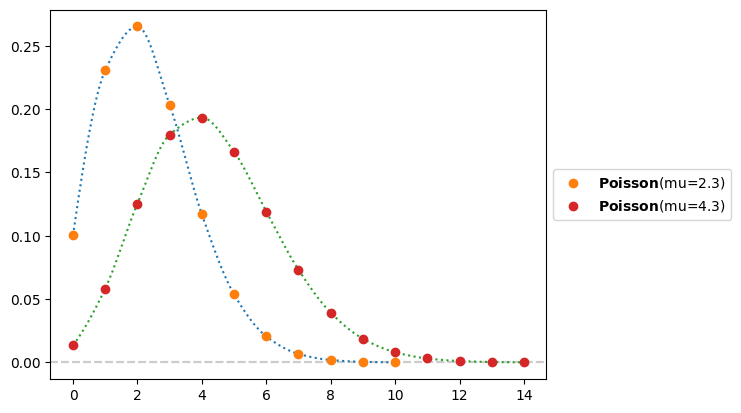

In [4]:
pz.Poisson(2.3).plot_pdf()
pz.Poisson(4.3).plot_pdf();

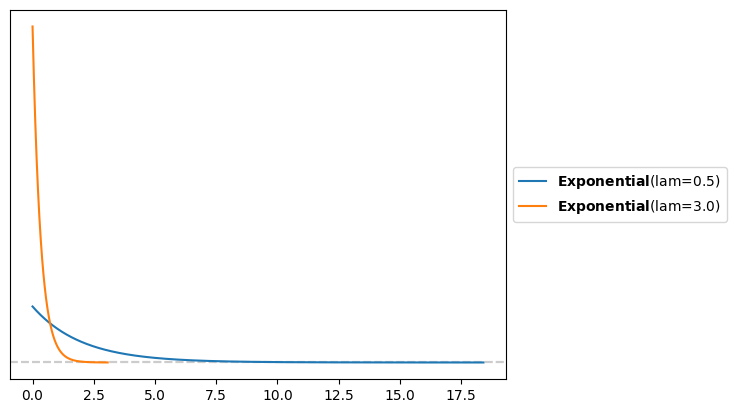

In [15]:
pz.Exponential(lam=0.5).plot_pdf()
pz.Exponential(lam=3.0).plot_pdf();

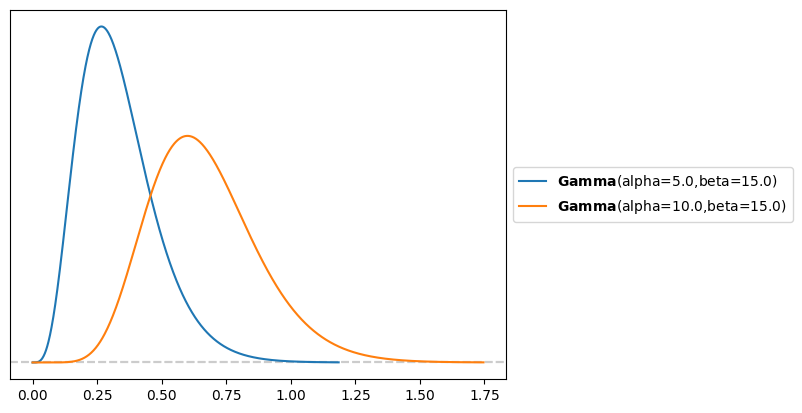

In [ ]:
pz.Gamma(alpha=5, beta=15).plot_pdf()
pz.Gamma(alpha=10, beta=15).plot_pdf();

<Axes: >

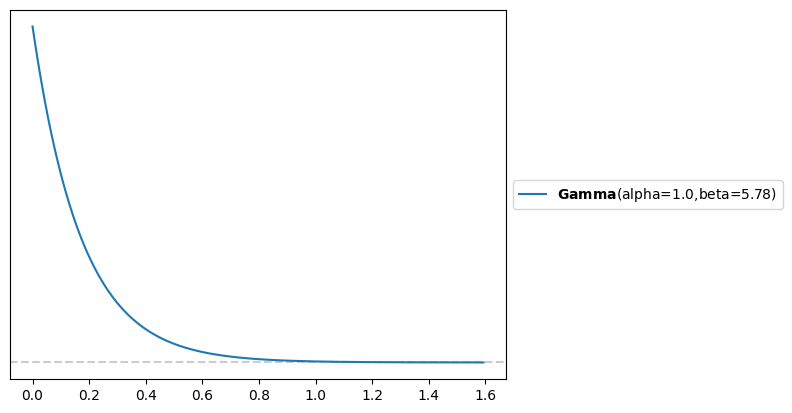

In [18]:
#shape = 0.371786
shape = 1
scale = 5.779949
pz.Gamma(alpha=shape, beta=scale).plot_pdf()

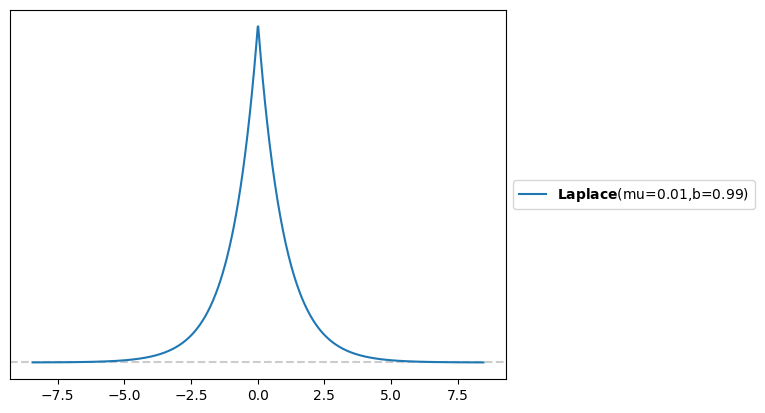

In [ ]:
# In a real scenario this will be some data and not a sample from a PreliZ distribution
sample = pz.StudentT(4, 0, 1).rvs(1000)

dist0 = pz.StudentT()
dist1 = pz.Normal()
dist2 = pz.Laplace()
pz.mle([dist0, dist1, dist2], sample);  # we ask to plot all 3 distributions

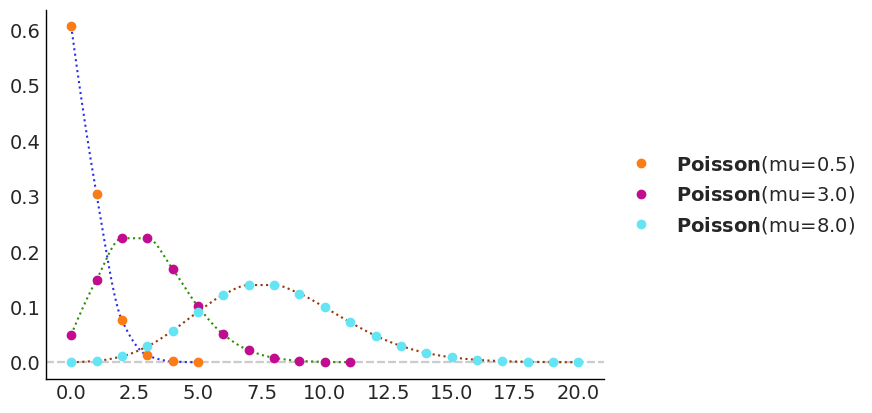

In [6]:
#import arviz as az
from preliz import Poisson
az.style.use('arviz-white')
for mu in [0.5, 3, 8]:
    Poisson(mu).plot_pdf()

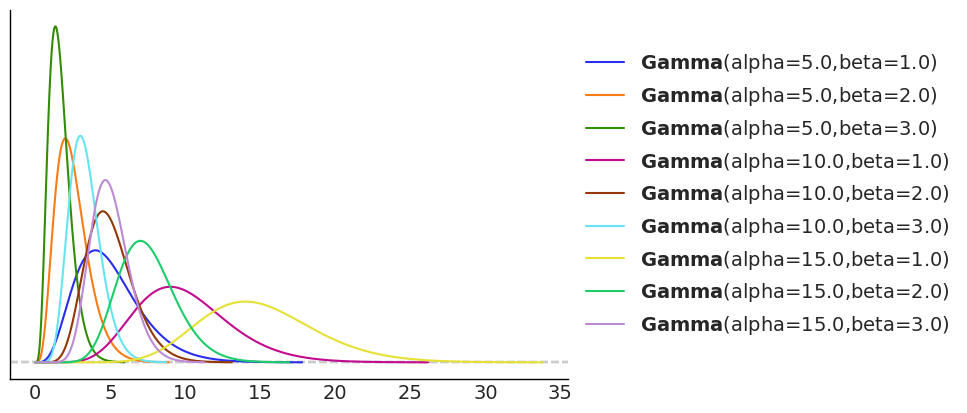

In [10]:
from preliz import Gamma
az.style.use('arviz-white')
for alpha in [5, 10, 15]:
    for beta in [1, 2, 3]:
        Gamma(alpha, beta).plot_pdf()


<Axes: title={'center': 'θ'}>

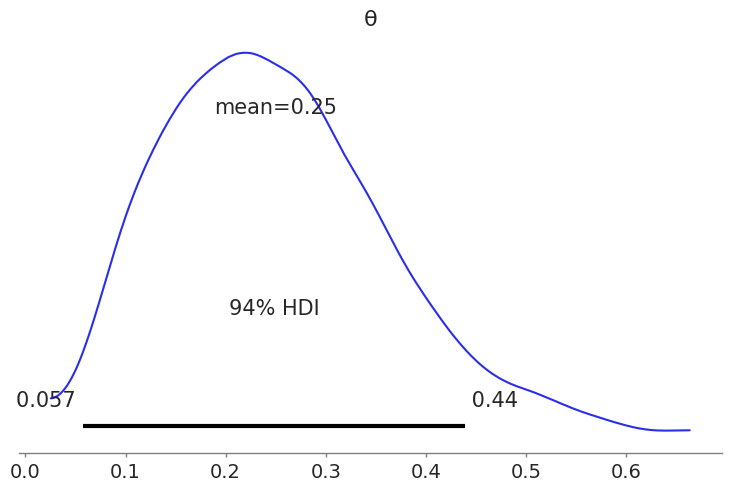

In [24]:
np2.random.seed(1)
az.plot_posterior({'θ':pz.Beta(4,12).rvs(1000)})

### PYMC - Coin Flipping Model

In [39]:
# Generate some coin flipping data
# In reality, theta will be unknown
# This is a great example of how increasing the dataset (trials) allows the
# Posterior to learn the theta_real value

np2.random.seed(123)

trials = 400
theta_real = 0.35
data = pz.Binomial(n=1, p=theta_real).rvs(trials)

In [ ]:
data

Recall our selection of Prior and Likelihood for coin flipping:  
Prior:  $\theta \sim Beta(\alpha = 1, \beta = 1) $  
Likelihood: $Y \sim Binomial(n=1, p=\theta)$

Now that we have the data (synthetic), we can now build the probabilistic model.
This is done by specifing a Prior and a Likelihood.

In [40]:
# Here we can change the number of chains (default was 2)
# Ultimately, we want all chains to explore the entire posterior.

with pm.Model() as coin_model:
    θ = pm.Beta('θ', alpha=1.0, beta=1.0)
    # y = pm.Binomial('y', n=1, p=θ, observed=data)
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000, chains=4)

Notes on above model. Data is entered through the likelihood via the `observed` variable.   
The `idata` variable is an `InferenceData` object which is a container for all the data generated by PyMC. On the last line we ask for 1,000 samples from the posterior. Typically some chains will be produced to increase the efficiency and reliability of the sampling method.

<Axes: title={'center': 'θ'}>

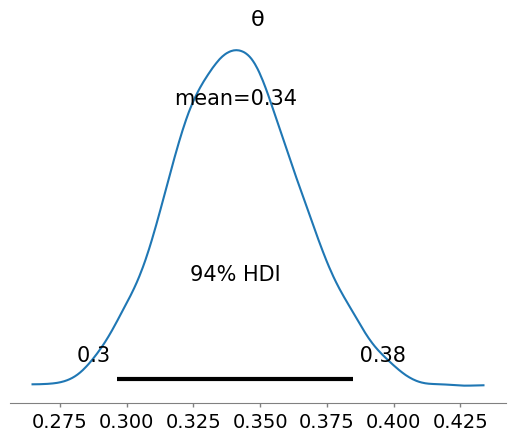

In [41]:
az.plot_posterior(idata)

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>]],
      dtype=object)

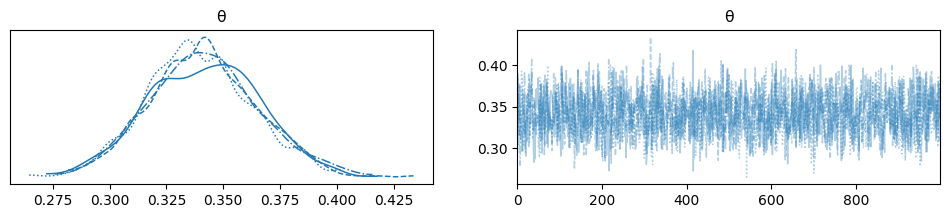

In [42]:
# With az.plot_trace() we get two subplots for each unobserved variable.
# The only unobserved variable in our model is theta.
# On left is a KDE for each chain (sampling from the posterior).
# On right are individual values at each sampling step, getting as many lines as chains.
# Ideally these indiivdiual value plots should look "noisy."

az.plot_trace(idata)

In [43]:
# Note: you get a distribution mean, not the mean of a bunch of numbers

az.summary(idata, kind='stats').round(2)

,mean,sd,hdi_3%,hdi_97%
θ,0.34,0.02,0.3,0.38


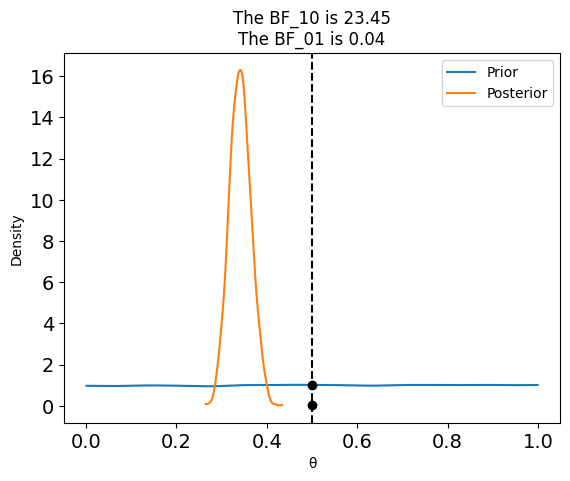

In [44]:
# Compute the Savage-Dickey Density Ratio:
# In order for this ratio to make sense, the bias of 0.5 has to fall within
# the support of the HDI. Else the BF_01 measure is nonsense.
# But the plot clearly shows that it is an unfair coin.

az.plot_bf(idata, var_name='θ', prior=np.random.uniform(0, 1, 10000), ref_val=0.5);

<Axes: title={'center': 'θ'}>

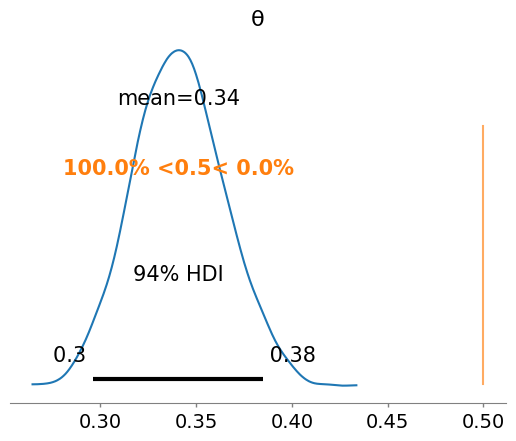

In [45]:
az.plot_posterior(idata, ref_val=0.5)

### Chemical Shift Model

In [2]:
# Mount Google Drive and copy file to Colab environment
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/My Drive/Data/chemical_shifts.csv" "chemical_shifts.csv"

Mounted at /content/drive


In [8]:
data = pd.read_csv('chemical_shifts.csv', header=None)

In [9]:
data.head()

,0
0,51.06
1,55.12
2,53.73
3,50.24
4,52.05


In [17]:
# Create the chemical_shift Bayesian Model
# Here we demonstrate that observed data can be a pandas dataframe

with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sigma=5)

    Y = pm.Normal('Y', mu=μ, sigma=σ, observed=data)
    idata_g = pm.sample()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

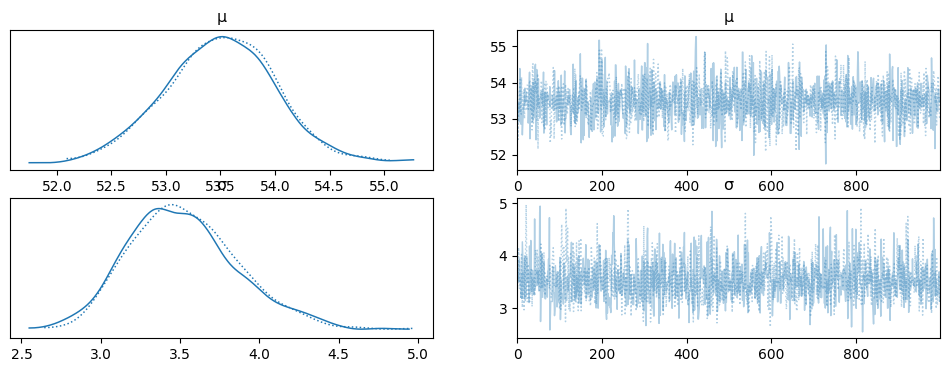

In [18]:
az.plot_trace(idata_g)

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

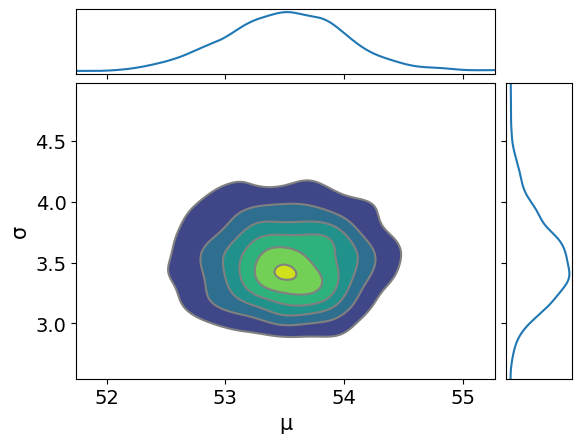

In [19]:
az.plot_pair(idata_g, kind='kde', marginals=True)

In [20]:
# Look at the summaries:
az.summary(idata_g, kind='stats').round(2)

,mean,sd,hdi_3%,hdi_97%
μ,53.50,0.51,52.51,54.42
σ,3.54,0.37,2.90,4.26


#### Posterior Predictive Checks

Once we have the posterior $P(\theta | Y)$, it is possible to use to make predictions $P(\hat{Y})$. We can think of this as the distirbuiton of future data, given the model and observed data. Using PyMC is easy to get posterior predictive samples; we do not need to compute an integral. We call the `sample_posterior_predictive` fucntion and pass the `InferenceData` object as the first argument. We also pass the model object.  
One common use of the posterior predictive distribution si to perform posterior predictive checks - check if the model is a good fit for the data.

In [23]:
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y / Y'>

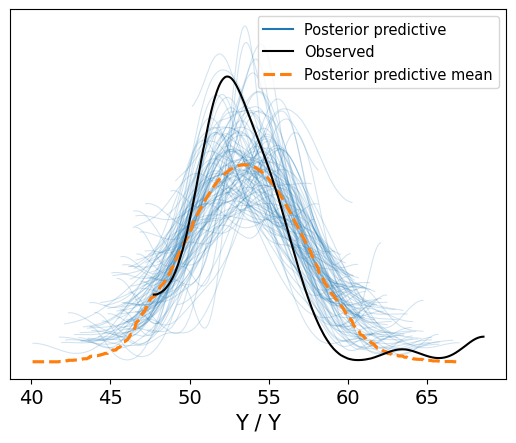

In [24]:
# We use the `plot_ppc` method from ArviZ to visualize the
# posterior predictive distribution and observed data.

az.plot_ppc(idata_g, num_pp_samples=100)

### MCMC
Using metropolis hastings.  

**MCMC Chain in action**  


1.   Inputs
*   init_proposal = 5
*   proposal_distribution = N(x, 0.5)
*   likelihood N(0,1)(x)

2.   Compute the likelihood of our initial proposal:  
L_init_prop = 1.487e-6 = L_curr_prop
3.   Propose a new state: new_proposal = N(init_proposal, 0.5) = 5.248
4.   Compute the likelihood of this proposed state: L_new_prop = 4.164e-7
5.   Compute the acceptance probability (ratio of likelihoods):  
accept_prob = L_new_prop / L_curr_prop = 0.280
6. Compute the acceptance threshold from a uniform distribution U[0,1)
accept_threshold = 0.732
7.   Compare the acceptance probability to the acceptance threshold.
If the acceptance probability is greater than the acceptance threshold, then keep the proposed state; else, keep the current state:
accept_prob > accept_threshold = False
8.   Repeat steps 2–6 until the predefined number of samples has been computed, or the chain has converged







In [1]:
import numpy as np
from plotly import express as px
from plotly import graph_objs as go

In [4]:
# initialize variables
np.random.seed(42)
initial_state = 5.0
n_samples = 1000

In [7]:
def metropolis_hasting_iterator(curr_state, verbose=True):
    proposal = np.random.normal(curr_state, 0.5)
    l_curr = np.exp(-curr_state**2 / 2) / np.sqrt(2 * np.pi)
    l_prop = np.exp(-proposal**2 / 2) / np.sqrt(2 * np.pi)
    accept_prob = l_prop / l_curr
    accept_thresh = np.random.uniform(0,1)

    if verbose:
        print(
            proposal,
            l_prop,
            accept_prob,
            accept_thresh,
            accept_prob > accept_thresh
        )

    if accept_prob > accept_thresh:
        return proposal

    return curr_state

def mcmc(initial_state=0, n_samples=1, verbose=False):
    chain = []
    curr_state = initial_state
    for _ in range(n_samples):
        curr_state = metropolis_hasting_iterator(
            curr_state,
            verbose=verbose
        )
        chain.append(curr_state)

    return chain

def plot_chain(chain):

    title = 'Example MCMC Chain with Standard Normal Likelihood'

    fig = px.line(y=chain, title=title)

    fig.update_layout({
        'plot_bgcolor': 'rgba(0,0,0,0)',
        'paper_bgcolor': 'rgba(0,0,0,0)',
    })

    fig.add_trace(
        go.Violin(
            y=chain,
            side='positive',
            xaxis="x2",
            yaxis="y2",
            showlegend=False
        )
    )

    width=1600
    height=800
    margins={'l':20, 'r':20, 't':50, 'b':20}

    layout = {
        'showlegend': False,
        'xaxis': {'domain': [0, 0.88]},
        'xaxis2': {'domain': [0.9, 1]},
        'yaxis2': {
            'anchor': 'x2',
        },
        "margin": margins,
        "width": width,
        "height": height

    }
    fig.update_layout(layout)
    fig.update_traces(line_color='orange', line_width=5)

    fig.show()


In [9]:
chain = mcmc(
    initial_state=initial_state,
    n_samples=n_samples,
    verbose=False
    )

In [10]:
plot_chain(chain)